In [1]:
import sys
sys.path.insert(0, "src")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, 
    InsetPosition,
    mark_inset
)

from calculations.initialize import tanhmin

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


# Edge Dislocations

In [2]:
def ux(x: float, y: float, poisson_ratio: float, bx: float, offset: np.array=None) -> float:
    """
    TODO

    Args:
        x (float): x coordinate
        y (float): y coordinate
        poisson_ratio (float):
        bx (float): x element of burgers vector
        offset (None|np.aray): offset for dislocation. If None, then offset is 0

    Returns:
        float: x component of displacement for an edge dislocation
    """

    if offset is None:
        offset = np.array([0, 0])

    x = x - offset[0]
    y = y - offset[1]

    denom = 2 * (1 - poisson_ratio) * (x**2 + y**2)
    ret = np.arctan2(y, x) + x * y / denom

    return bx / (2 * np.pi) * ret


def uy(x: float, y: float, poisson_ratio: float, by: float, offset:np.array=None) -> float:
    """
    TODO

    Args:
        x (float): x coordinate
        y (float): y coordinate
        poisson_ratio (float):
        by (float): y element of burgers vector
        offset (None|np.aray): offset for dislocation. If None, then offset is 0

    Returns:
        float: y component of displacement for an edge dislocation
    """

    if offset is None:
        offset = np.array([0, 0])

    x = x - offset[0]
    y = y - offset[1]

    sum1 = 1 - 2 * poisson_ratio
    sum1 /= 4 * (1 - poisson_ratio)
    sum1 *= np.log(x**2 + y**2)

    sum2 = x**2 - y**2
    sum2 /= 4 * (1 - poisson_ratio) * (x**2 + y**2)

    return - by/(2 * np.pi) * (sum1 + sum2)


def density(
    x: float, 
    y: float, 
    G: np.array, 
    etas: np.array, 
    u: np.array
) -> np.array:
    """
    TODO

    Args:
        x (float):
        y (float):
        G (np.array): reciprocal vectors
        etas (np.array): amplitude magnitudes
        u (np.array): displacement

    Returns:
        np.array: TODO
    """

    eta_count = etas.shape[0]
    r = np.array([x, y])

    imag = complex(0, 1)

    n = np.zeros(x.shape, dtype=complex)
    for i in range(eta_count):

        amplitude = etas[i].astype(complex)
        amplitude *= np.exp(imag * (G[i, 0] * r[0] + G[i, 1] * r[1]))
        amplitude *= np.exp(imag * (G[i, 0] * u[0] + G[i, 1] * u[1]))

        n += amplitude

    n += np.conj(n)

    if np.max(np.imag(n)) != 0.0:
        print("WARNING: Im[n] != 0")

    n = np.real(n)

    return n


def Q_op(arr: np.array, dr: float, G: np.array, axis: int, conj: bool=False) -> float:
    """
    TODO

    Args:
        arr (np.array):
        dr (np.array): grid spacing
        G (np.array):
        axis (int): 0 for x, 1 for y
        conj (bool): If True, complex conjugate of operator is used.

    Returns:
        float:
    """
    
    ret_rhs = arr.copy().astype(complex)
    ret_rhs *= complex(0, 1) * G[axis]

    ret_lhs = arr.copy()
    ret_lhs = np.gradient(arr, dr, axis=int(not bool(axis)))

    return ret_lhs + int(conj) * ret_rhs


def laplacian(arr: np.array, dr: float) -> np.array:

    grad_y, grad_x = np.gradient(arr, dr)
    grad2_x = np.gradient(grad_x, dr, axis=1)
    grad2_y = np.gradient(grad_y, dr, axis=0)

    return grad2_x + grad2_y


def G_op(arr: np.array, dr: float, G: np.array):

    grad_y, grad_x = np.gradient(arr, dr)
    grad2 = laplacian(arr, dr)

    ret = 2 * complex(0,1) * (G[0] * grad_x + G[1] * grad_y)

    return grad2.astype(complex) + ret


def calc_stress(etas: np.array, G: np.array, dr: float, axes=[0, 1]) -> np.array:
    """
    TODO

    Args:
        etas (np.array):
        G (np.array): recipricol vectors
        dr (float): grid spacing
        axes (list, optional): Should have 2 entries Defines the tensor indeces. 
            0 = x, 1 = y. So an axes of :code:`[0, 1]` corresponds to 
            :math:`\\sigma_{xy}`, while an axes of :code:`[1, 1]` corresponds to
            :math:`\\sigma_{yy}`. Defaults to [0, 1].

    Returns:
        np.array: 
    """

    eta_count: int = etas.shape[0]

    stress = np.zeros(etas[0].shape, dtype=complex)
    for m in range(eta_count):
        
        p1 = G_op(etas[m], dr, G[m])
        p1 = Q_op(p1, dr, G[m], axis=axes[0])

        p2 = Q_op(np.conj(etas[m]), dr, G[m], axis=axes[1], conj=True)
        p3 = G_op(etas[m], dr, G[m])

        p4 = Q_op(np.conj(etas[m]), dr, G[m], axis=axes[1], conj=True)
        p4 = Q_op(p4, dr, G[m], axis=axes[0], conj=True)

        stress += p1 * p2 + p3 * p4

    stress = stress + np.conj(stress)

    if np.max(np.imag(stress)) != 0.0:
        print("WARNING: Im[\sigma] != 0")

    stress = np.real(stress)

    return stress


def reconstruct_u(axis: int, m: int, l: int, etas: np.array, G: np.array) -> np.array:
    """
    Reconstruct displacement from the amplitudes :code:`\\eta_m`

    Args:
        axis (int): 0 means reconstruct u_x, 1 means reconstruct u_y
        m (int): arbitrary index for amplitude, :math:`m \\neq l`
        l (int): arbitrary index for amplitude, :math:`m \\neq l`
        etas (np.array): complex amplitudes
        G (np.array): reciprocal vectors

    Returns:
        np.array: u_x or u_y
    """

    i = axis
    j = int(not bool(i))

    ang = lambda x: np.arctan2(np.imag(x), np.real(x))

    numer = G[l,j] * ang(etas[m]) - G[m,j] * ang(etas[l])
    denom = G[m,i] * G[l,j] - G[m,j] * G[l,i]

    return numer / denom

# From file 2D

In [35]:
BASE_PATH = "/home/max/projects/strained_apfc/data"

#sim_name = "052d_1linedef"
#sim_name = "052d_2linedef_vertical"
#sim_name = "052d_2linedef_horizontal"
#sim_name = "052d_4linedef"
sim_name = "052d_4linedef_mod"

compare_name: str|None = "052d"

fig_save_path = f"/home/max/projects/strained_apfc/docs/sphinx/source/updates/2023-09-13/{sim_name}"

index = -1
dpi = 500

sim_path = f"{BASE_PATH}/{sim_name}"
compare_path: str = f"{BASE_PATH}/{compare_name}"

In [36]:
from manage import utils
from manage import read_write as rw

config = utils.get_config(sim_path)
eta_path = f"{sim_path}/eta_files/0.0000/"

eta_count = len(config["G"])
include_n0 = config["simType"] == "n0"

etas = rw.read_all_etas_at_line(
    eta_path, index, config["numPtsX"], config["numPtsY"], eta_count, complex
)

n0 = 0
if include_n0:
    n0 = rw.read_arr_at_line(
        f"{eta_path}/n0.txt", index, config["numPtsX"], config["numPtsY"]
    )


x = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
xm, ym = np.meshgrid(x, x)
r = np.array([xm, ym])
imag = complex(0,1)
G = np.array(config["G"])

split_etas = np.zeros(etas.shape, dtype=float)
for i in range(etas.shape[0]):
    x_cut = etas[i].shape[0] // 2
    split_etas[i] = np.imag(etas[i])
    split_etas[i, :, x_cut:] = np.real(etas[i, :, x_cut:])

phi = np.zeros(etas[0].shape)
for i in range(etas.shape[0]):
    phi += np.real(etas[i] * np.conj(etas[i]))
phi *= 2

n = np.zeros(etas[0].shape, dtype=complex)
if include_n0:
    n += n0
for i in range(etas.shape[0]):
    ampl = etas[i].copy()
    ampl *= np.exp(imag * (G[i, 0] * r[0] + G[i, 1] * r[1]))
    n += ampl

n += np.conj(n)

if np.max(np.imag(n)) != 0.0:
    print("WARNING: Im[n] != 0")

n = np.real(n)

ux = reconstruct_u(0, 0, 2, etas, G)
uy = reconstruct_u(1, 0, 2, etas, G)

dr = np.abs(np.diff(x)[0])

stress_xy = calc_stress(etas, G, dr, axes=[0,1])
stress_xx = calc_stress(etas, G, dr, axes=[0,0])
stress_yy = calc_stress(etas, G, dr, axes=[1,1])

if compare_name is not None:

    compare_config = utils.get_config(compare_path)
    compare_eta_path = f"{compare_path}/eta_files/0.0000/"

    compare_etas = rw.read_all_etas_at_line(
        compare_eta_path, 
        index, 
        compare_config["numPtsX"], 
        compare_config["numPtsY"], 
        eta_count, 
        complex
    )

    compare_phi = np.zeros(etas[0].shape)
    for i in range(etas.shape[0]):
        compare_phi += np.real(compare_etas[i] * np.conj(compare_etas[i]))
    compare_phi *= 2

    compare_diff = (compare_phi - phi)**2

    compare_diff_n0 = 0
    if include_n0:
        compare_n0 = rw.read_arr_at_line(
            f"{compare_eta_path}/n0.txt", 
            index, 
            compare_config["numPtsX"], 
            compare_config["numPtsY"]
        )

        compare_diff_n0 = compare_n0 - n0
        compare_diff_n0 *= np.conj(compare_diff_n0)
        compare_diff_n0 = np.real(compare_diff_n0)

In [37]:
def plot_etas_re_im(
    xm,
    ym,
    etas, 
    cbar_y0=0.07, 
    cbar_height=0.05, 
    wspace=0.05, 
    hspace=0.05, 
    dpi=100, 
    cbar_ticks=5,
    contourf_color_count=100,
    cmap="coolwarm",
    fig_save_path=None
):
    
    fig, axs = plt.subplots(2, 3, dpi = dpi)

    eta_max = -1e10
    eta_min = 1e10

    eta_max = np.max([eta_max, np.max(np.real(etas))])
    eta_max = np.max([eta_max, np.max(np.imag(etas))])
    eta_min = np.min([eta_min, np.min(np.real(etas))])
    eta_min = np.min([eta_min, np.min(np.imag(etas))])

    ticks_cbar = np.linspace(eta_min, eta_max, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(eta_min, eta_max, contourf_color_count, endpoint=True)

    for i in range(etas.shape[0]):

        ax_re = axs[0][i]
        ax_im = axs[1][i]

        ax_re.set_aspect("equal")
        ax_im.set_aspect("equal")

        ax_re.set_title(f"$\\mathrm{{Re}}\\left[\\eta_{i+1}\\right]$")
        ax_im.set_title(f"$\\mathrm{{Im}}\\left[\\eta_{i+1}\\right]$")
        
        ax_re.set_xticklabels([])
        ax_re.set_yticklabels([])
        ax_im.set_xticklabels([])
        ax_im.set_yticklabels([])

        cont = ax_re.contourf(xm, ym, np.real(etas[i]), ticks_plot, cmap=cmap)
        cont.set_clim(eta_min, eta_max)

        cont = ax_im.contourf(xm, ym, np.imag(etas[i]), ticks_plot, cmap=cmap)
        cont.set_clim(eta_min, eta_max)

    pos = [
        axs[1][0].get_position().x0,
        axs[1][0].get_position().y0 - cbar_y0,
        axs[1][-1].get_position().x0 + axs[1][-1].get_position().width - axs[1][0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__etas.png")

def plot_stresses(
    xm, 
    ym,
    stress_xy, 
    stress_xx, 
    stress_yy, 
    dpi=100, 
    cbar_tics=5, 
    contourf_color_count=100, 
    cmap="coolwarm",
    cbar_y0=0.085, 
    cbar_height=0.05, 
    wspace=0.05, 
    hspace=0.05,
    fig_save_path=None
):

    fig, axs = plt.subplots(nrows=1, ncols=3, dpi=dpi)
    ax1, ax2, ax3 = axs

    stresses = (stress_xy, stress_xx, stress_yy)
    stress_max = -1e10
    stress_min = 1e10
    for stress in stresses:
        stress_min = np.min([stress_min, np.min(stress)])
        stress_max = np.max([stress_max, np.max(stress)])

    ticks_cbar = np.linspace(stress_min, stress_max, cbar_tics, endpoint=True)
    ticks_plot = np.linspace(stress_min, stress_max, contourf_color_count, endpoint=True)

    for ax, stress in zip(axs, stresses):

        ax.set_aspect("equal")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        cont = ax.contourf(xm, ym, stress, ticks_plot, cmap=cmap)
        cont.set_clim(stress_min, stress_max)

    ax1.set_title("$\\sigma_{xy}$")
    ax2.set_title("$\\sigma_{xx}$")
    ax3.set_title("$\\sigma_{yy}$")

    pos = [
        axs[0].get_position().x0,
        axs[0].get_position().y0 - cbar_y0,
        axs[-1].get_position().x0 + axs[-1].get_position().width - axs[0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__stress.png")

def plot_displacement(
    xm, 
    ym, 
    ux, 
    uy, 
    dpi=100, 
    cmap="coolwarm",
    cbar_ticks=5,
    contourf_color_count=100,
    cbar_y0=0.07, 
    cbar_height=0.025, 
    wspace=0.05, 
    hspace=0.05,
    fig_save_path=None
):

    max_ = np.max(ux)
    max_ = np.max([max_, np.max(uy)])
    min_ = np.min(ux)
    min_ = np.min([min_, np.min(uy)])

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    fig, axs = plt.subplots(1, 2, dpi=dpi)
    ax_x, ax_y = axs

    for ax in axs:
        ax.set_aspect("equal")
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    cont = ax_x.contourf(xm, ym, ux, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    cont = ax_y.contourf(xm, ym, uy, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    ax_x.set_title("$u_x$")
    ax_y.set_title("$u_y$")

    pos = [
        axs[0].get_position().x0,
        axs[0].get_position().y0 - cbar_y0,
        axs[-1].get_position().x0 + axs[-1].get_position().width - axs[0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__u.png")

def plot_phi_and_density(
    xm, 
    ym, 
    phi, 
    n, 
    contourf_color_count=100, 
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.07, 
    cbar_height=0.025,
    wspace=0.05, 
    hspace=0.05,
    inset_size=20,
    inset_window_pos=[0.6, 0.6, 0.3, 0.3],
    inset_offset=np.array([0,0]),
    show_inset=True,
    fig_save_path=None
):
    fig = plt.figure(dpi=dpi)
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    gen_conturf_plot(
        xm, ym, phi, fig, ax1, 
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height
    )
    ax1.set_title("$\Phi$")
    if show_inset:
        plot_density_w_inset(
            xm, ym, n, inset_size, offset=inset_offset,
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height,
            ax=ax2,
            fig=fig,
            inset_window_pos=inset_window_pos
        )
    else:
        gen_conturf_plot(
            xm, ym, n, fig, ax2, 
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height
        )
    ax2.set_title("$n(r, u)$")

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__phi_density.png")


def gen_conturf_plot(
    xm, 
    ym, 
    arr,
    fig,
    ax,
    contourf_color_count=100, 
    cbar_ticks=5,
    cmap="coolwarm",
    cbar_y0=0.07, 
    cbar_height=0.025
):
    
    min_ = np.min(arr)
    max_ = np.max(arr)
    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    cont = ax.contourf(xm, ym, arr, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    pos = [
        ax.get_position().x0,
        ax.get_position().y0 - cbar_y0,
        ax.get_position().width,
        cbar_height
    ]
    cax = fig.add_axes(pos)

    fig.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)


def plot_density_w_inset(
    xm, 
    ym, 
    n, 
    size, 
    offset=np.array([0, 0]),
    contourf_color_count=100, 
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.05, 
    cbar_height=0.025,
    wspace=0.05, 
    hspace=0.05,
    ax=None,
    fig=None,
    inset_window_pos=[0.6, 0.6, 0.3, 0.3],
    fig_save_path=None
):
    
    xm_in_bounds = np.logical_and(xm[0,:] < offset[1]+size, xm[0,:] > offset[1]-size)
    ym_in_bounds = np.logical_and(ym[:,0] < offset[0]+size, ym[:,0] > offset[0]-size)

    xm_inset = xm[np.ix_(xm_in_bounds, ym_in_bounds)]
    ym_inset = ym[np.ix_(xm_in_bounds, ym_in_bounds)]
    n_inset = n[np.ix_(xm_in_bounds, ym_in_bounds)]

    min_ = np.min(n)
    max_ = np.max(n)

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    if ax is None or fig is None:
        fig = plt.figure(dpi=dpi)
        ax = plt.subplot(111)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)

    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    cont = ax.contourf(xm, ym, n, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    #####

    ax_inset = plt.axes([0,0,1,1])
    inset_pos = InsetPosition(ax, inset_window_pos)
    ax_inset.set_axes_locator(inset_pos)

    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec='0')

    ax_inset.set_aspect("equal")
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])

    cont = ax_inset.contourf(xm_inset, ym_inset, n_inset, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    pos = [
        ax.get_position().x0,
        ax.get_position().y0 - cbar_y0,
        ax.get_position().width,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    fig.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__density_w_inset.png")

def plot_diff(
    xm, 
    ym, 
    diff_etas, 
    diff_n0,
    contourf_color_count=100, 
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.05, 
    cbar_height=0.025,
    wspace=0.05, 
    hspace=0.05,
    fig_save_path=None
):
    
    fig = plt.figure(dpi=dpi)

    if diff_n0 is not None:
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
    else:
        ax1 = plt.subplot(111)
        ax2 = None

    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    gen_conturf_plot(
        xm, ym, diff_etas, fig, ax1, 
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height
    )
    ax1.set_title("$|\Phi_d - \Phi|^2$")

    if diff_n0 is not None:
        gen_conturf_plot(
            xm, ym, diff_n0, fig, ax2, 
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height
        )
        ax2.set_title("$|n_{0,d} - n_0|^2$")

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__comp.png")

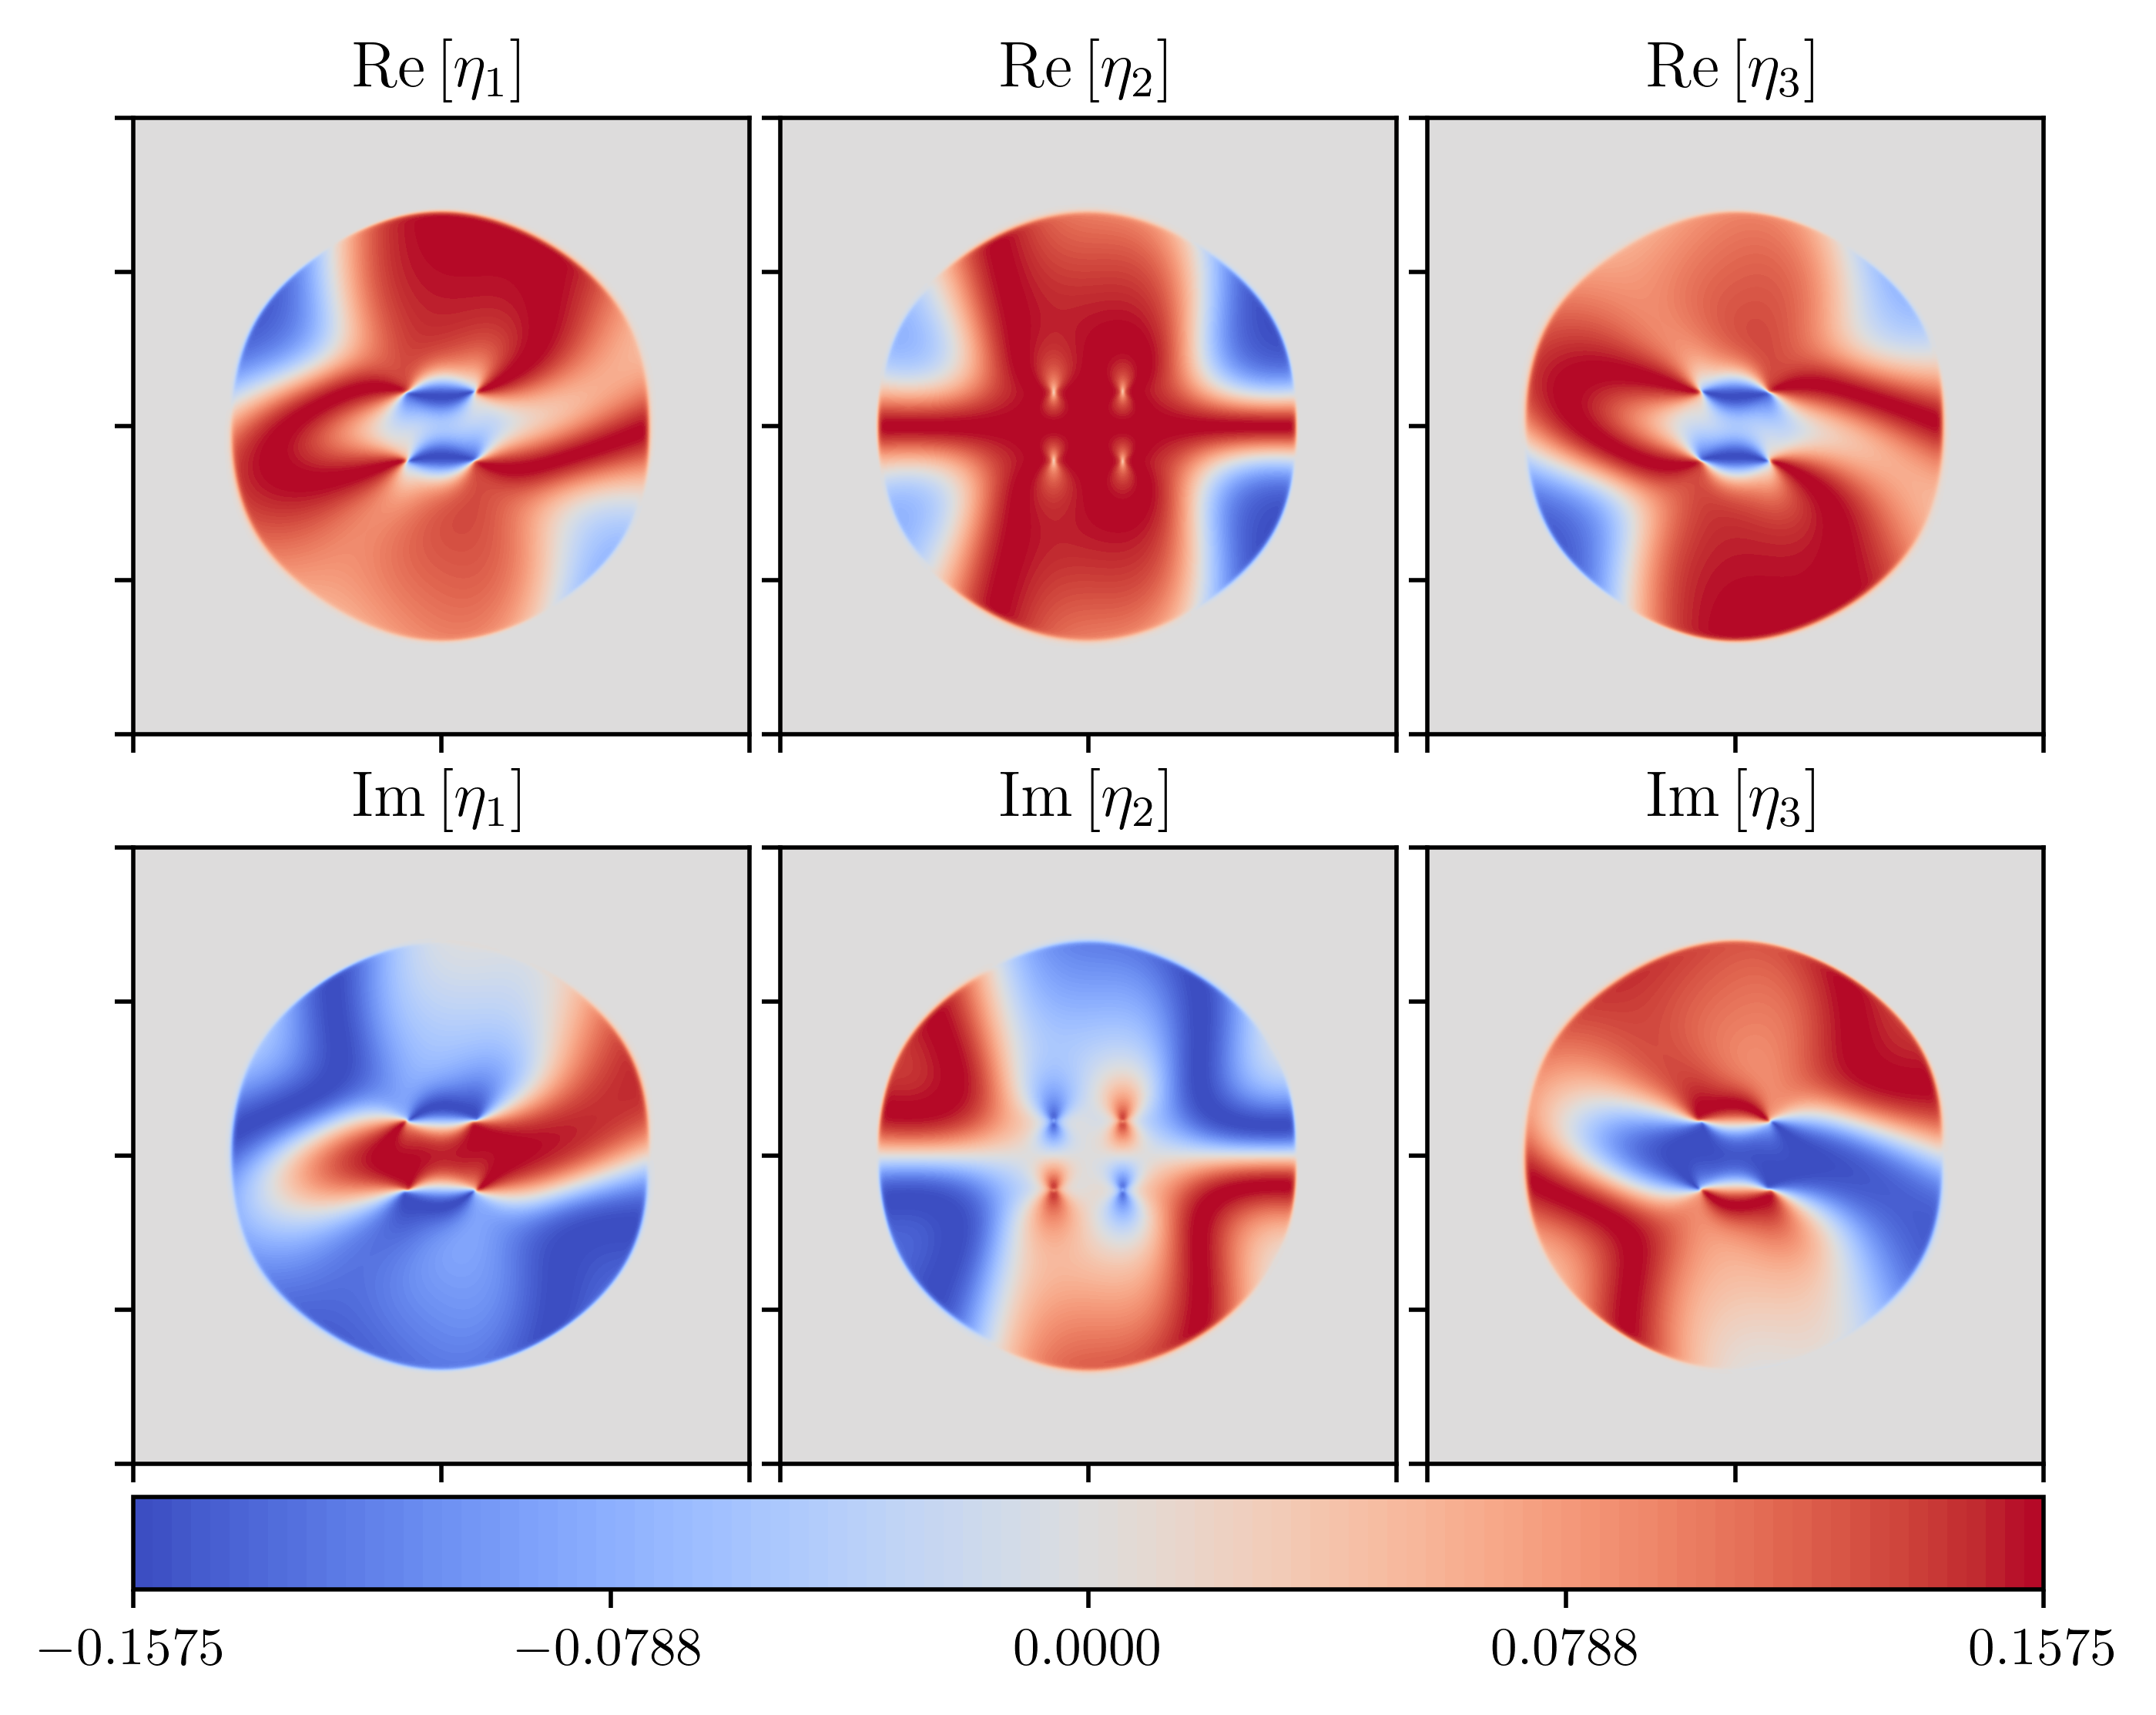

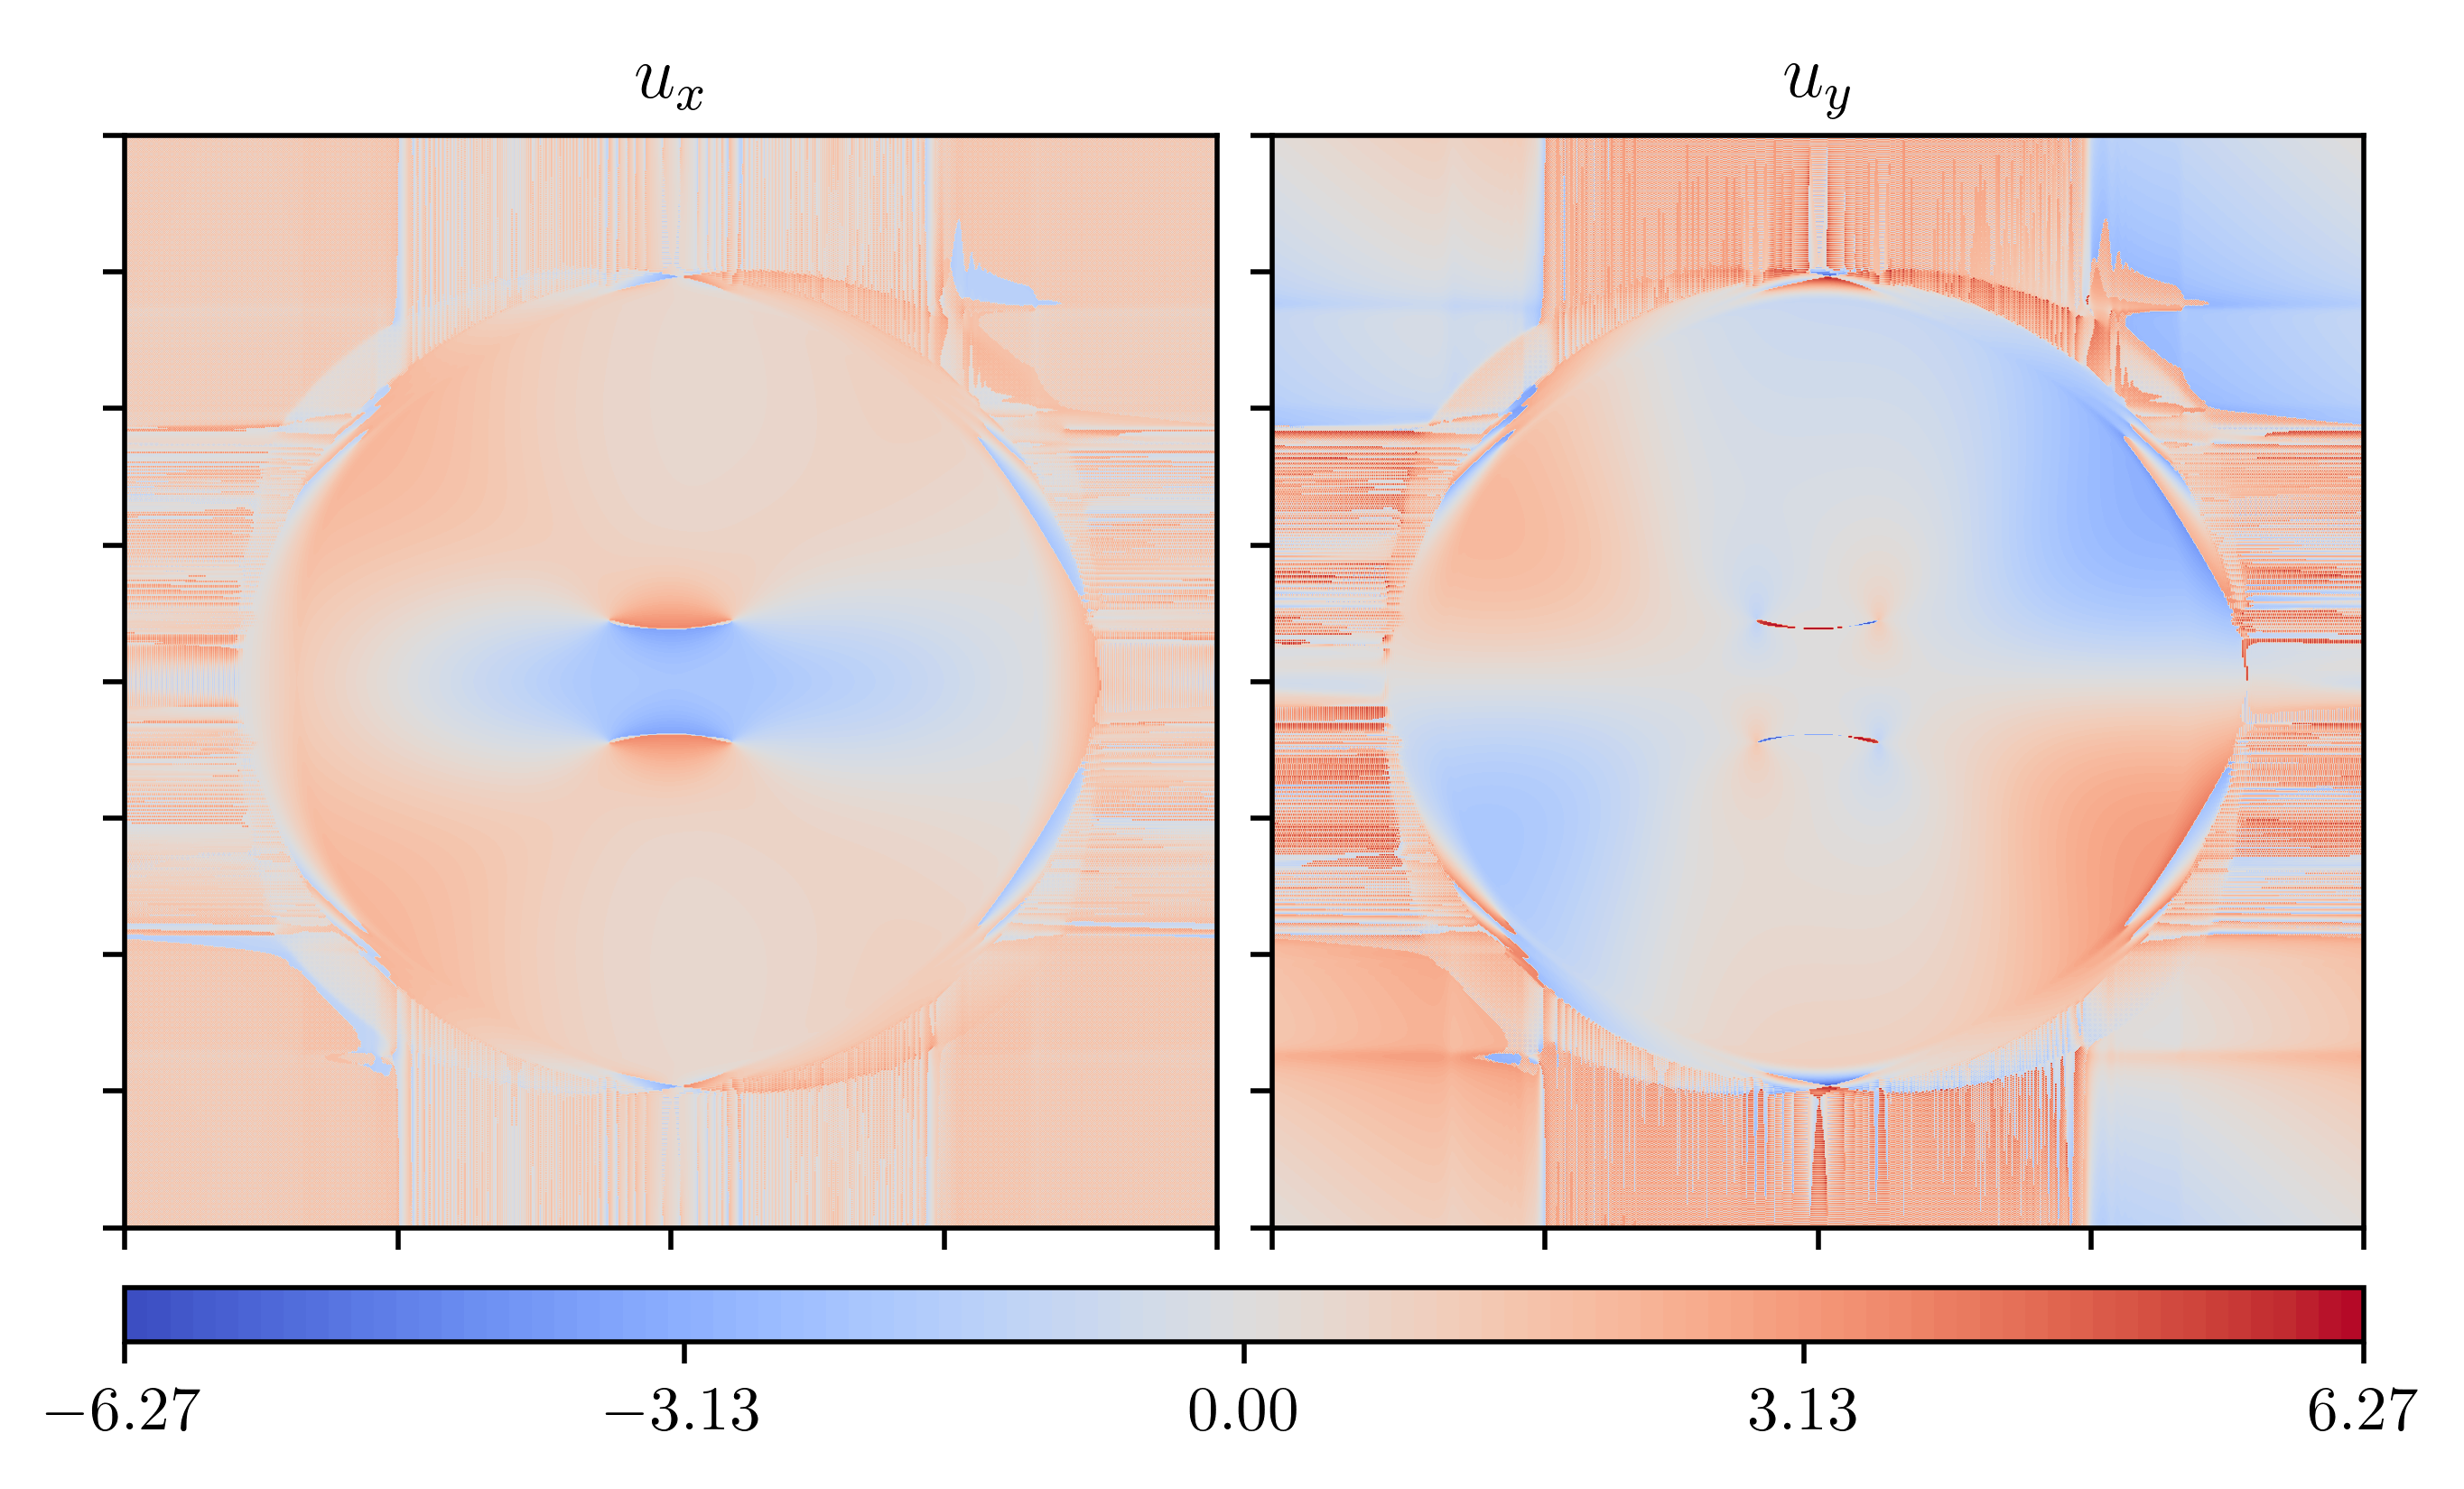

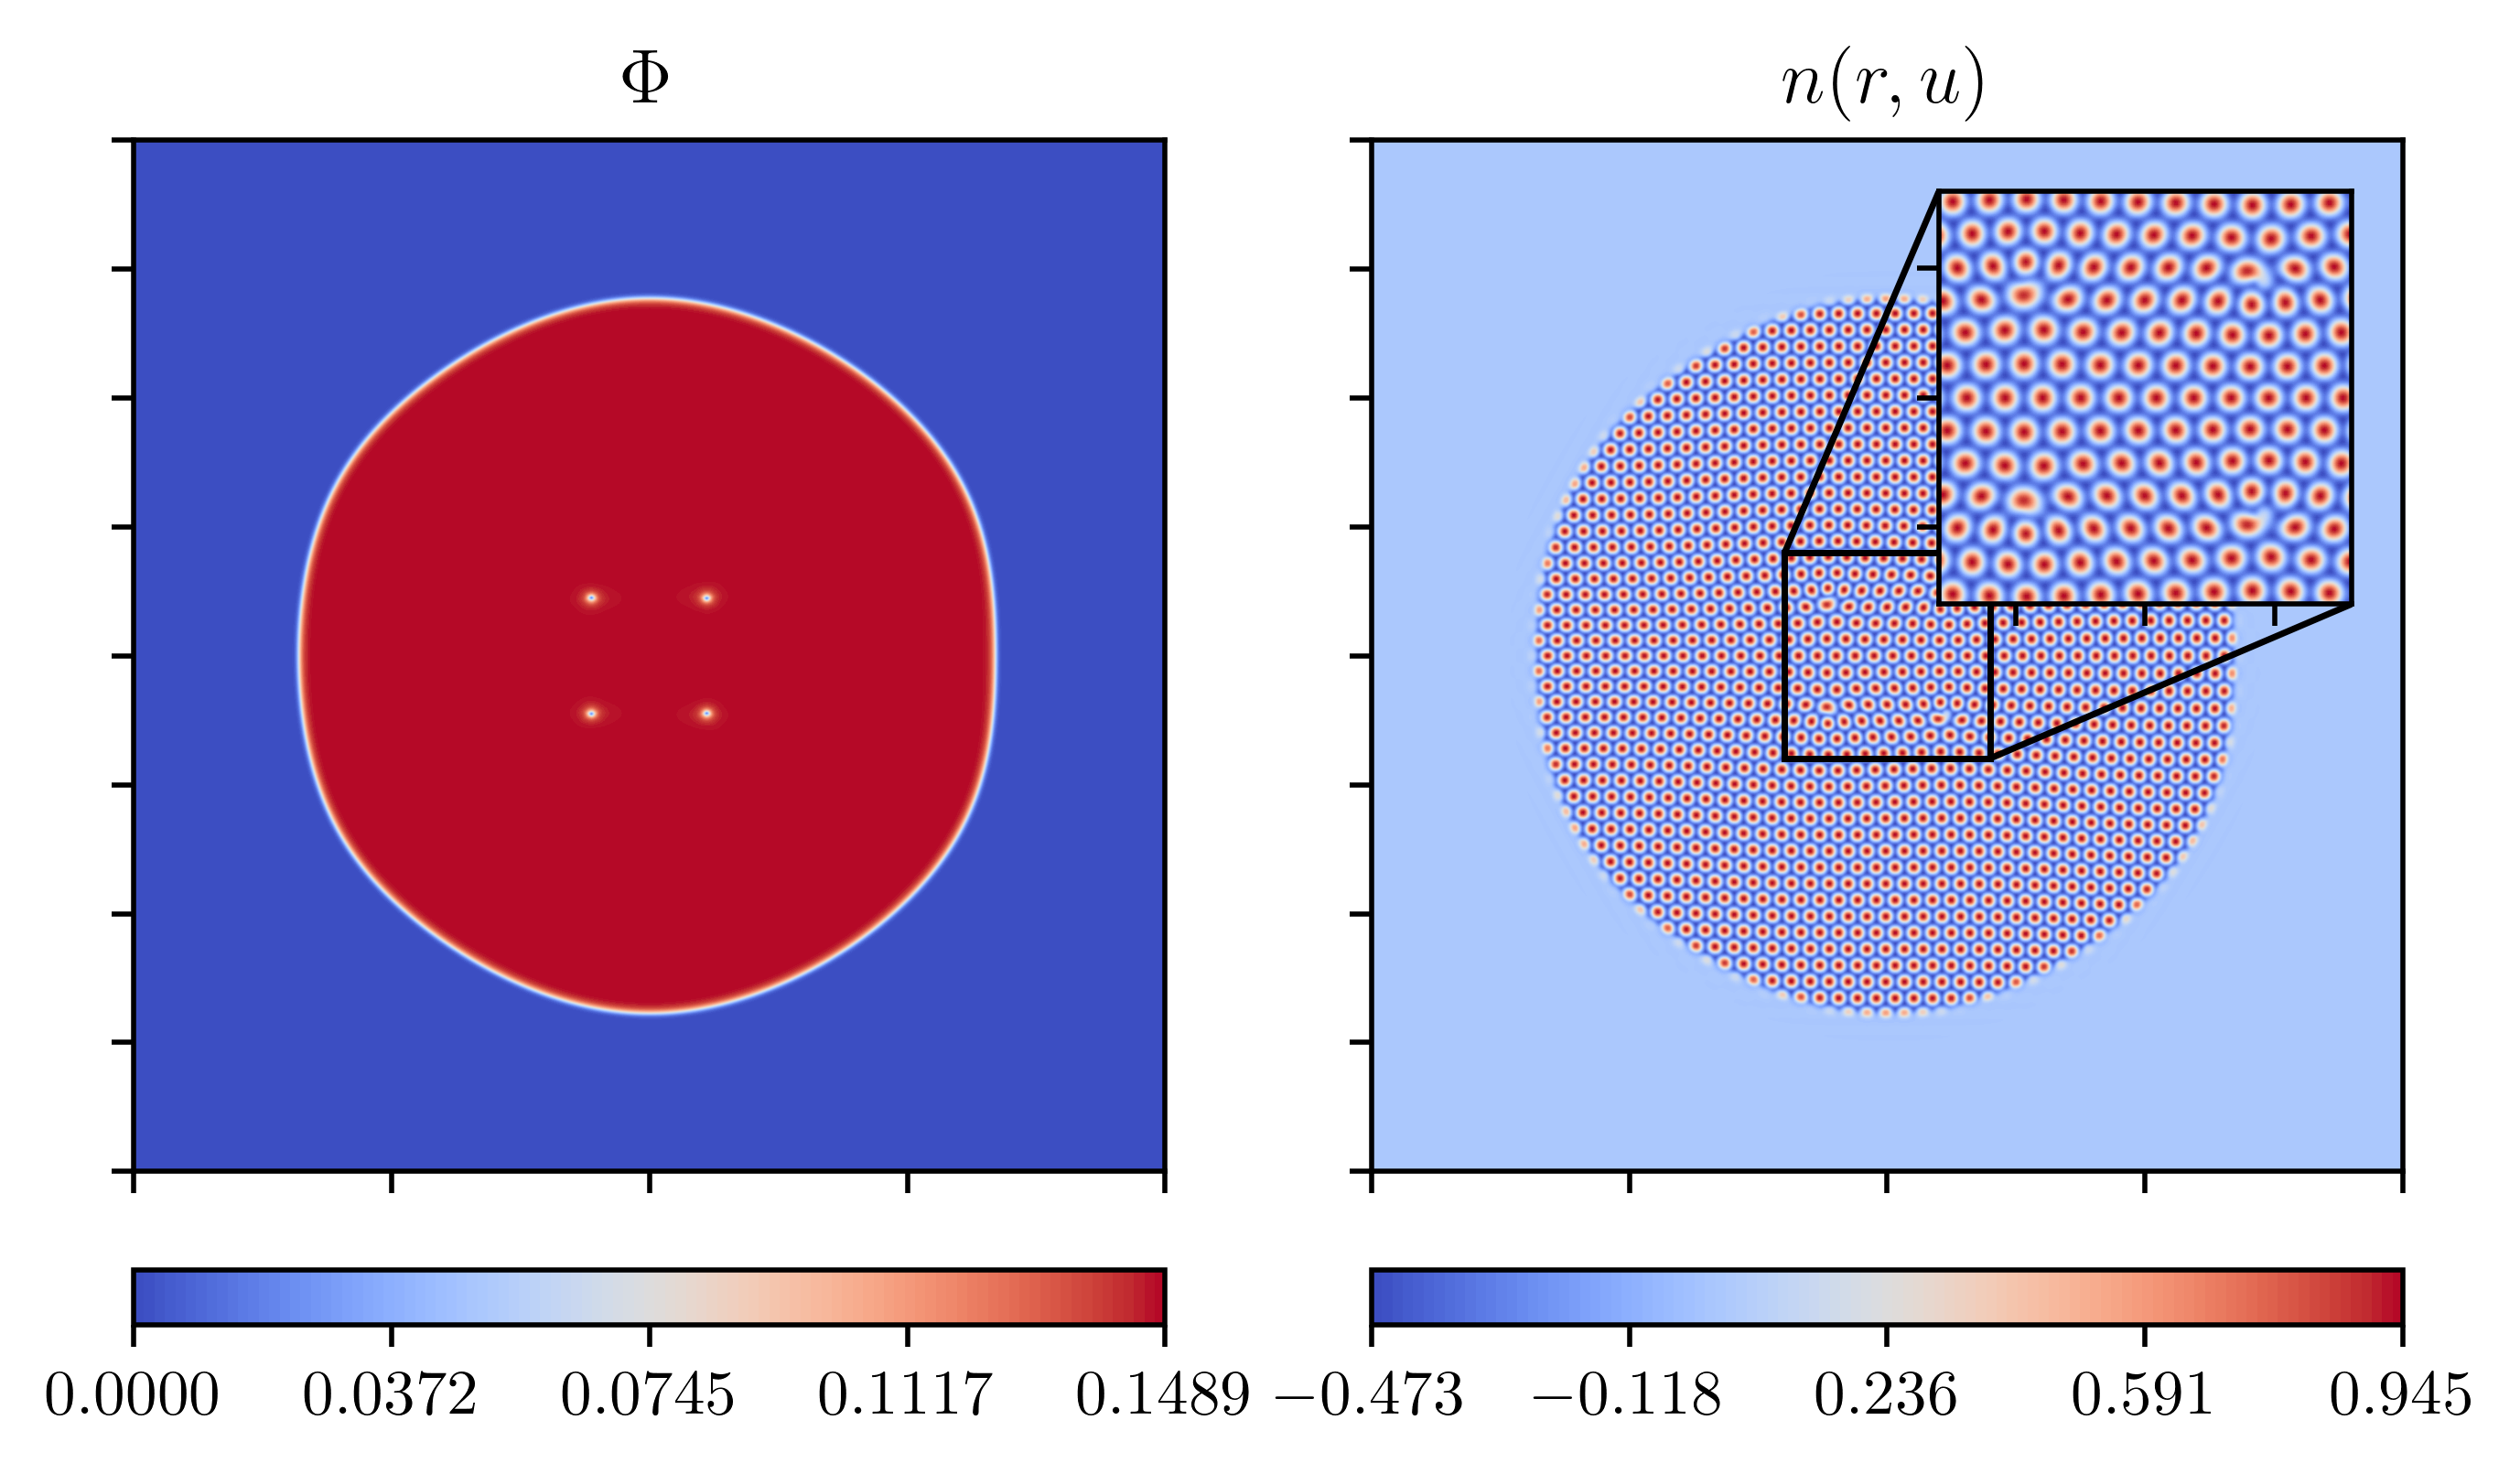

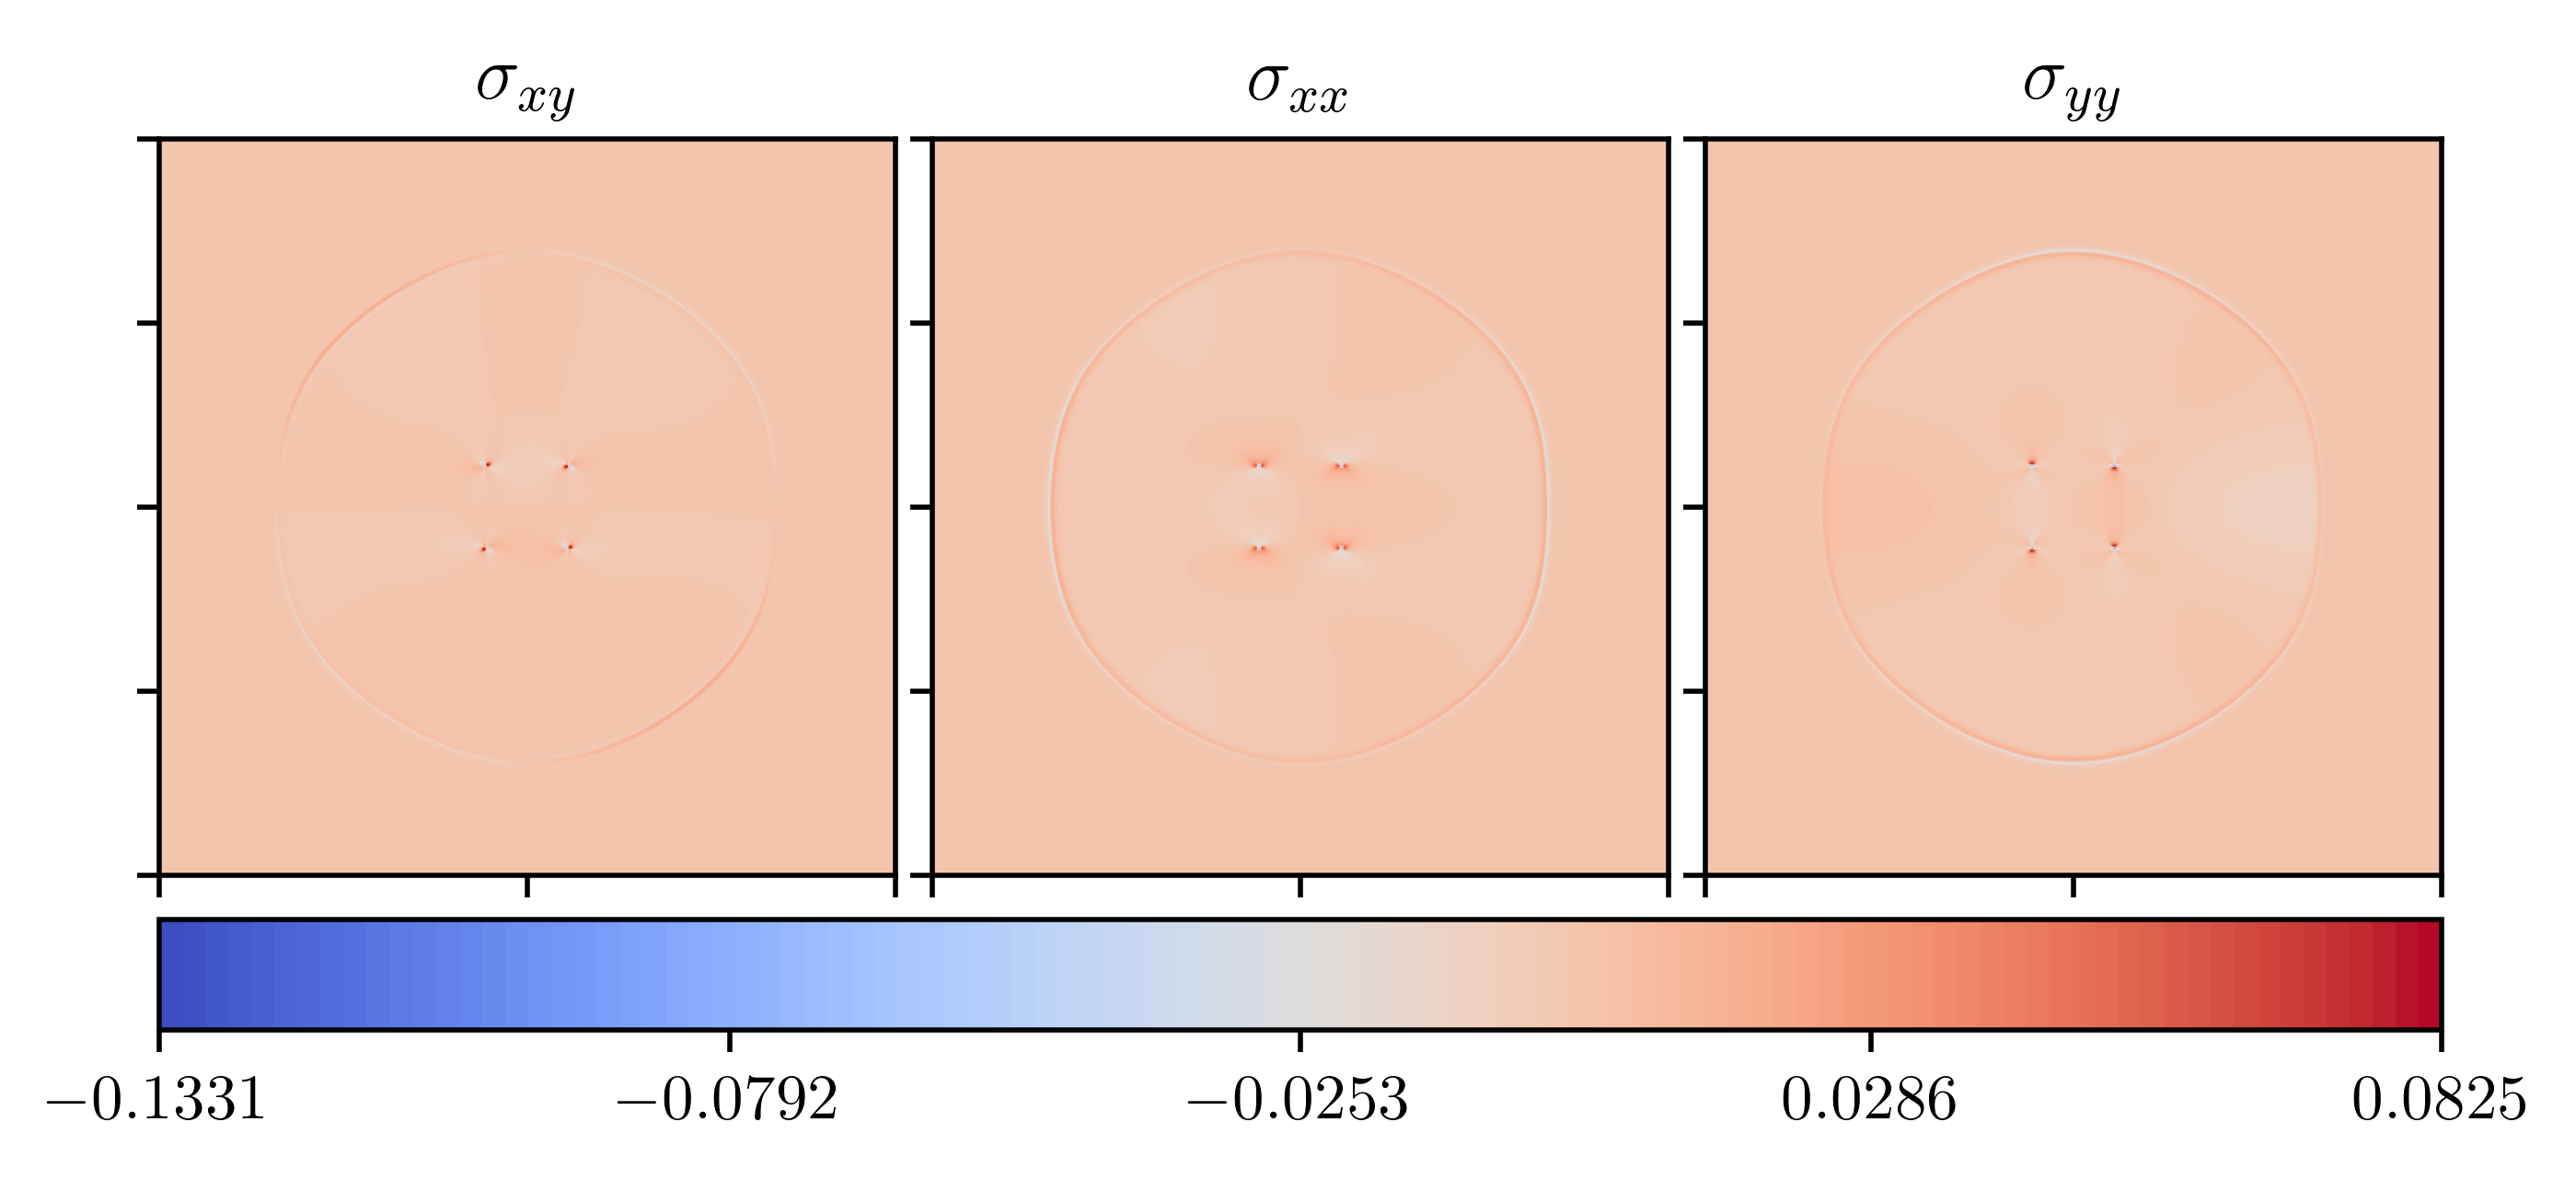

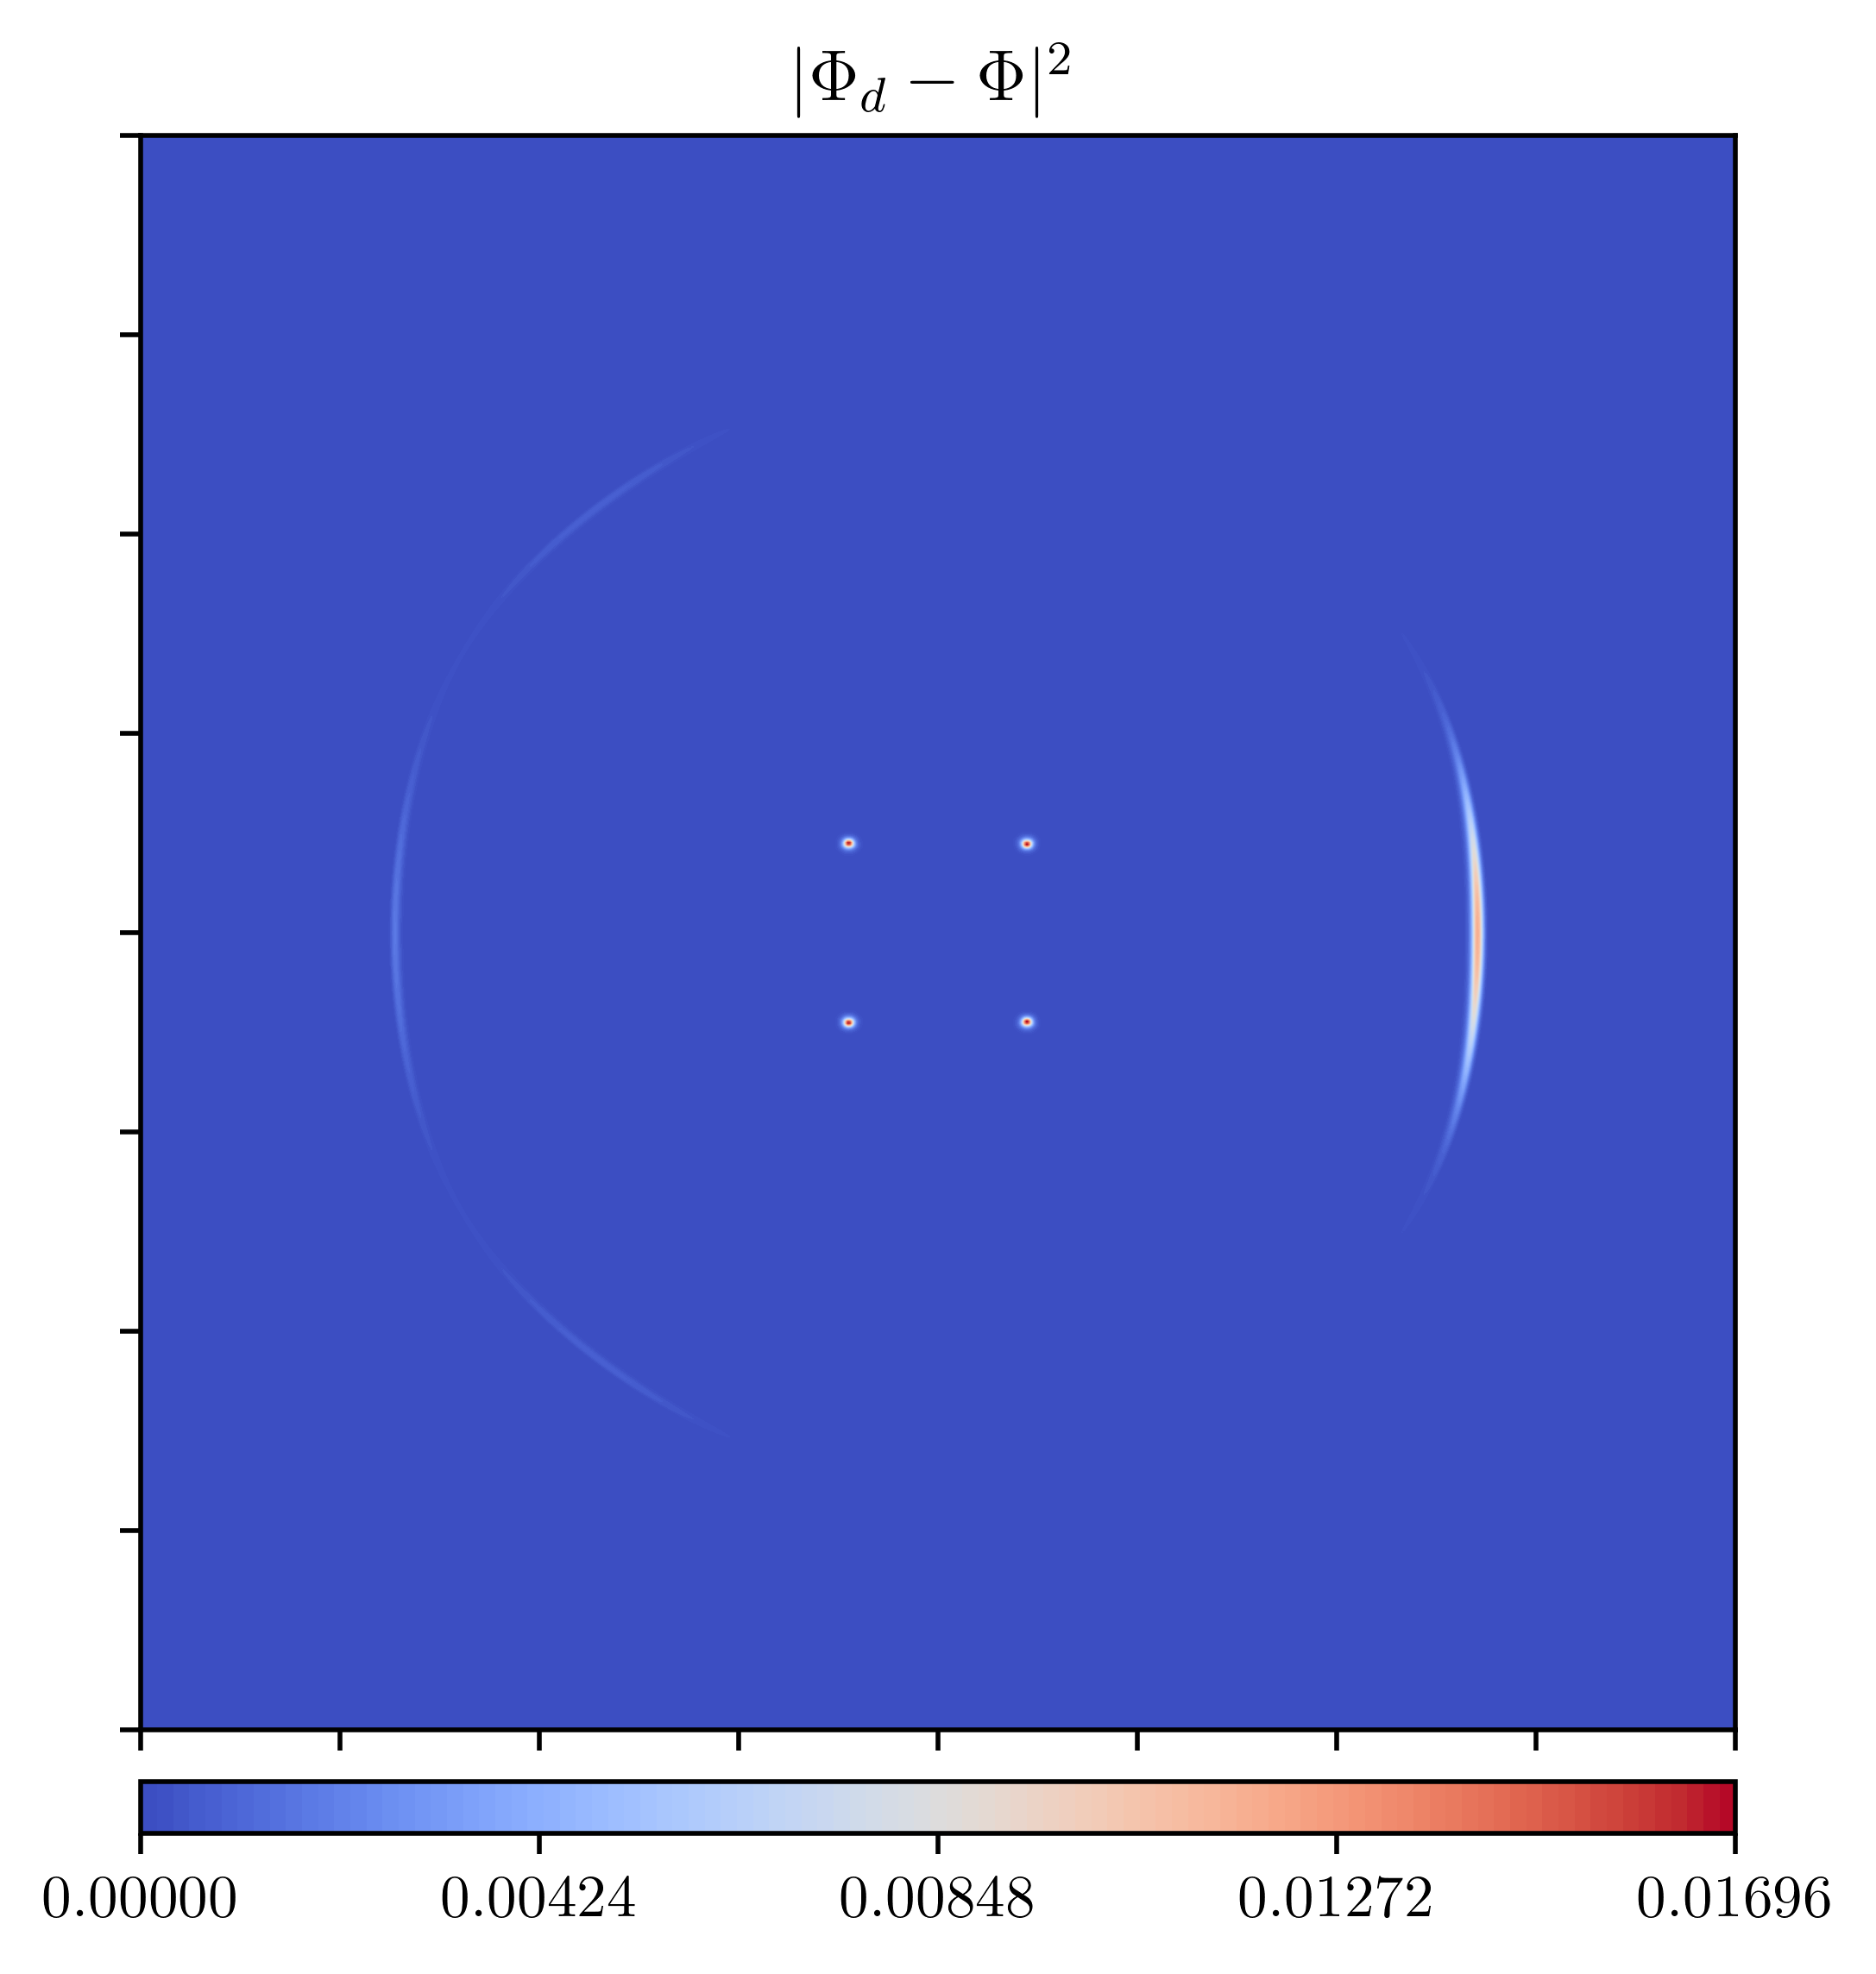

In [38]:
#############
### PLOTS ###
#############

plot_etas_re_im(xm, ym, etas, dpi=dpi, fig_save_path=fig_save_path)
plot_displacement(xm, ym, ux, uy, dpi=dpi, fig_save_path=fig_save_path)
plot_phi_and_density(
    xm, ym, phi, n, dpi=dpi, 
    inset_size=40, inset_offset=[0,0], show_inset=True,
    inset_window_pos=[0.55, 0.55, 0.4, 0.4],
    wspace=0.2, fig_save_path=fig_save_path
)
#plot_density_w_inset(xm, ym, n, 10, offset=[0, 0], dpi= dpi)
plot_stresses(xm, ym, stress_xy, stress_xx, stress_yy, dpi=dpi, fig_save_path=fig_save_path)
plot_diff(xm, ym, compare_diff, compare_diff_n0 if include_n0 else None, dpi=dpi, fig_save_path=fig_save_path)

plt.show()